Tutorial 5: Borders
===================

In the previous tutorial, we told our `Inversion` to use a border. Here, we'll discuss what this border does.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

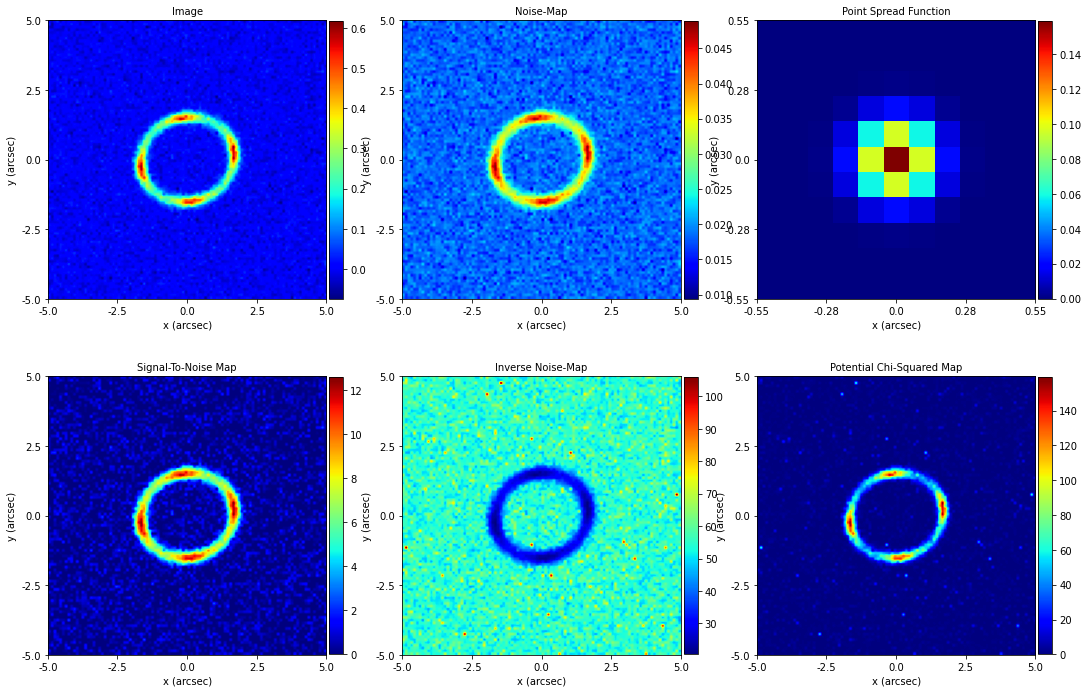

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

So, what is a border? In the image-plane, a border is the set of exterior pixels in a mask that are at, well, its 
border. Lets plot the image with a circular `Mask2D`, and tell our `ImagingPlotter`.to plot the border as well.

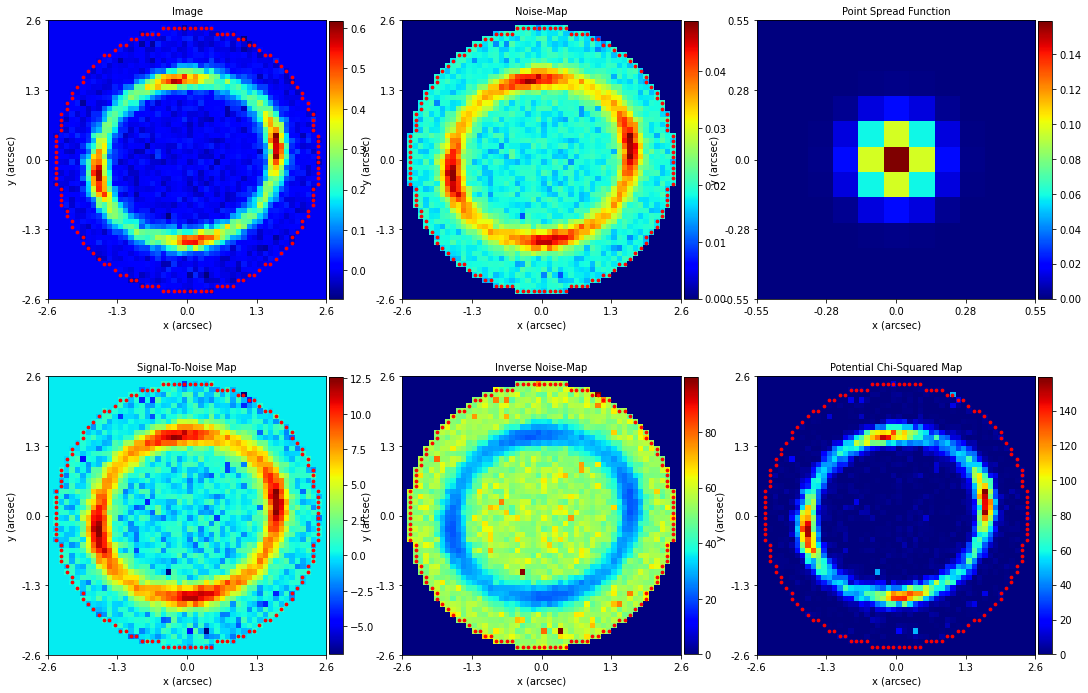

In [3]:
mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_circular)

include_2d = aplt.Include2D(border=True)

imaging_plotter = aplt.ImagingPlotter(imaging=masked_imaging, include_2d=include_2d)
imaging_plotter.subplot_imaging()

As you can see, for a circular `Mask2D`, the border *is* the edge of our `Mask2D` (the ring of black dots we're used to 
seeing whenever we plot a `Mask2D`.. For an annular `Mask2D`, not every pixel on the edge of the mask is necessarily a 
part of its border!

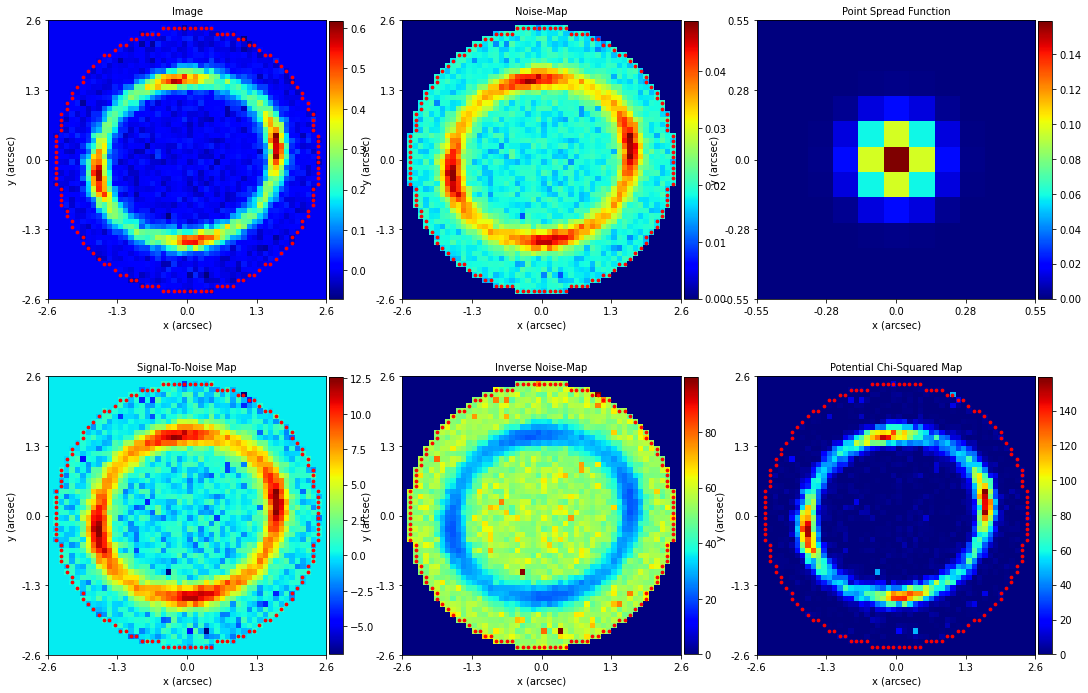

In [4]:
mask_annular = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    inner_radius=0.8,
    outer_radius=2.5,
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_circular)

imaging_plotter = aplt.ImagingPlotter(imaging=masked_imaging, include_2d=include_2d)
imaging_plotter.subplot_imaging()

Indeed, a border is *only* the pixels at the exterior edge of our `Mask2D`, which for the annular _Mask- above means 
non of the pixels at the inner radius = 0.8" edge are part of the border.

So, what does a border actually do? To show you, we'll need to fit this image with a lens model and `Mapper` and we'll 
do that by using the same function as the previous tutorial (to perform a quick source galaxy fit) but with the option 
to input a mask and use a border.

In [5]:


def perform_fit_with_source_galaxy_mask_and_border(
    imaging, source_galaxy, mask, settings_pixelization
):

    masked_imaging = al.MaskedImaging(
        imaging=imaging, mask=mask, settings=al.SettingsMaskedImaging(sub_size=2)
    )

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllipticalIsothermal(
            centre=(0.0, 0.0),
            einstein_radius=1.6,
            elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
        ),
        shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(
        masked_imaging=masked_imaging,
        tracer=tracer,
        settings_pixelization=settings_pixelization,
    )


Okay, so lets first look at our `Mapper` without using a border using our annular `Mask2D`.

First, note how we set up the border. We use a `SettingsPixelization` object, which is analogous to the 
`SettingsMaskedImaging` and `SettingsLens` objects we used in previous tutorials. Later, you'll see how these 
settings can also be passed to a `SettingsPhaseImaging` object, to control the behaviour of the `Pixelization` during a
model-fit.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


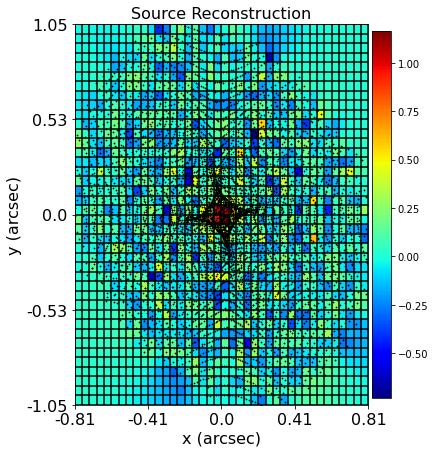

In [6]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.0),
)

fit = perform_fit_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_annular,
    settings_pixelization=al.SettingsPixelization(use_border=False),
)

include_2d = aplt.Include2D(mapper_source_grid_slim=True)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_of_planes(plane_image=True, plane_index=1)

Everything looks fine - we get a reconstructed source on a visually appeasing source-plane grid. So, why are we so 
worried about borders? Lets see what happens if we use a circular mask instead.

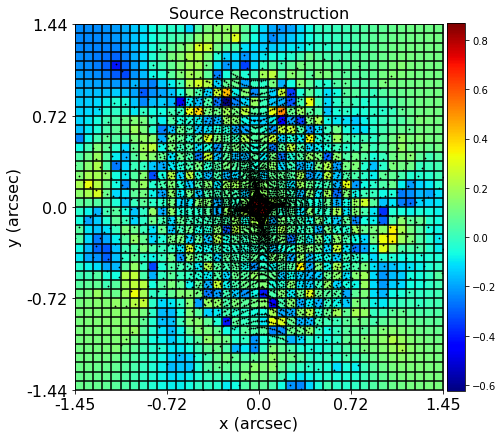

In [7]:
fit = perform_fit_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=False),
)

inversion_plotter = aplt.InversionPlotter(
    inversion=fit.inversion, include_2d=include_2d
)
inversion_plotter.figures(reconstruction=True)

Woah - whats happened? There are lots of extra points on our source-plane `Grid2D` which trace to extremely large radii 
away from the central regions of the source-plane! These points are traced image-pixels (just like all the other points) 
which correspond to the central image-pixels that our annular `Mask2D` masked but that our circular `Mask2D` didn`t!

Lets quickly check this using a `Mapper` `Plotter`.

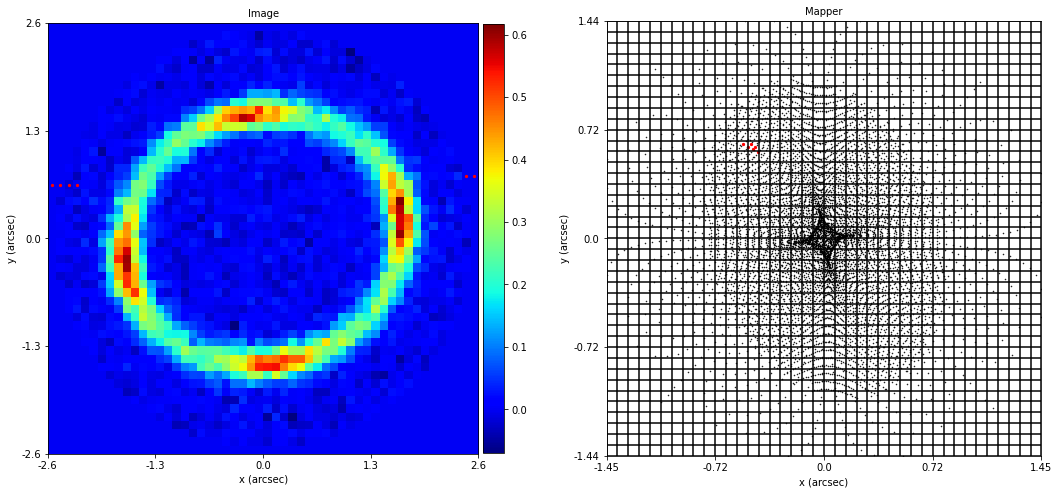

In [8]:
visuals_2d = aplt.Visuals2D(indexes=[986, 987, 988, 989, 990, 991])
include_2d = aplt.Include2D(mapper_source_grid_slim=True)

mapper_plotter = aplt.MapperPlotter(
    mapper=fit.inversion.mapper, visuals_2d=visuals_2d, include_2d=include_2d
)

mapper_plotter.subplot_image_and_mapper(image=fit.masked_imaging.image)

So, whats happening physically? Towards the centre of our `EllipticalIsothermal` `MassProfile`.the density profile 
becomes extremely cuspy (rising very sharply). This cause extremely large deflection angles to be computed, lets have 
a quick look.

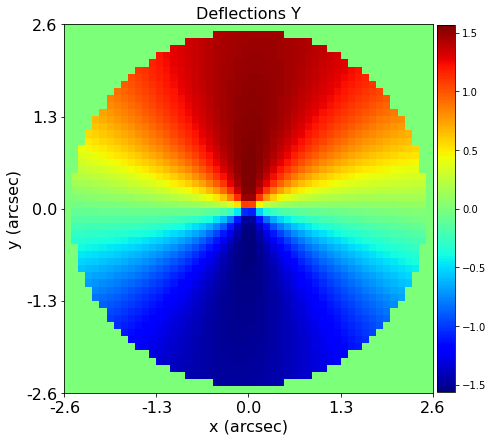

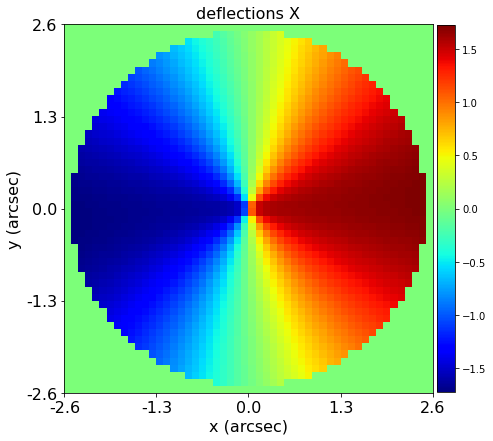

In [9]:
tracer_plotter = aplt.TracerPlotter(tracer=fit.tracer, grid=fit.grid)
tracer_plotter.figures(deflections_y=True, deflections_x=True)

This means that our central image pixels are highly demagnified, tracing to extremely large values in the source plane! 

Physically, this isn't a problem, it just means that we don't see a `central image` in most strong lenses as light-rays 
which trace through the centre of the lens are demagnified. However, if the lens galaxy had a cored mass distribution 
we would see the central image.

This is a problem for our `Pixelization` and `Mapper`, which in the source-plane fits these demagnified pixels like 
any other pixels. This has two negative consequences:

 1) The `Rectangular` `Pixelization`.we `overlay` over the source-plane is much larger than for the annular `Mask2D` 
 because it has to expand to include the demagnified image-pixels. As a result, large source-pixels are used to 
 reconstruct the central regions of the source-plane (where the source galaxy is actually located), meaning we 
 reconstruct the source-galaxy at a lower effective resolution.
    
 2) The `Rectangular` `Pixelization`.reconstructs the flux of the demanigified image pixels using source-pixels 
 which contain *only* demagnified image pixels. However, these source-pixels *should* have other image-pixels 
 traced within them from pixels at large radii from the centre of the lens galaxy. Unfortunately, our circular 
 `Mask2D` masks these pixels out, meaning they do not make it to our source-plane and are omitted from the source 
 reconstruction.

Lets quickly use a larger circular `Mask2D` to confirm that these pixels do exist, if we don't mask them.

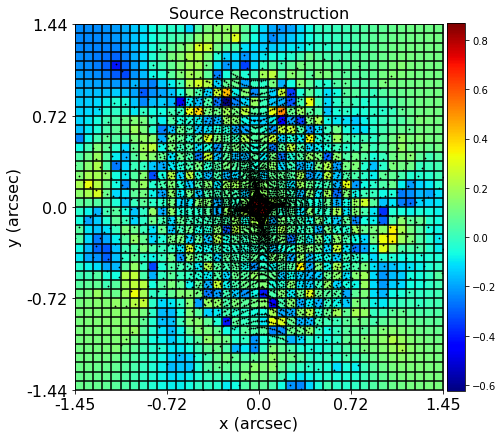

In [10]:
mask_circular_large = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=4.0
)

fit = perform_fit_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=False),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_of_planes(plane_image=True, plane_index=1)

This second point is a *huge* problem, as allowing source-pixels to fit regions of our mask in this completely 
unphysical way introduces extremely dangerous systematics into our source reconstruction and lens model analysis. 
You can see this in the weird patterns these pixels make in the exterior regions of our source-reconstruction!

Borders are the solution to this problem. We simply take the `Mask2D` border in the image-plane we showed above, trace 
it to the source-plane and relocate all traced image-pixels pixels outside this source-plane border to its edge. Lets 
take a look.

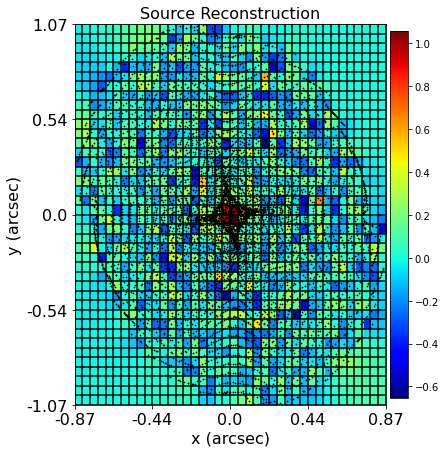

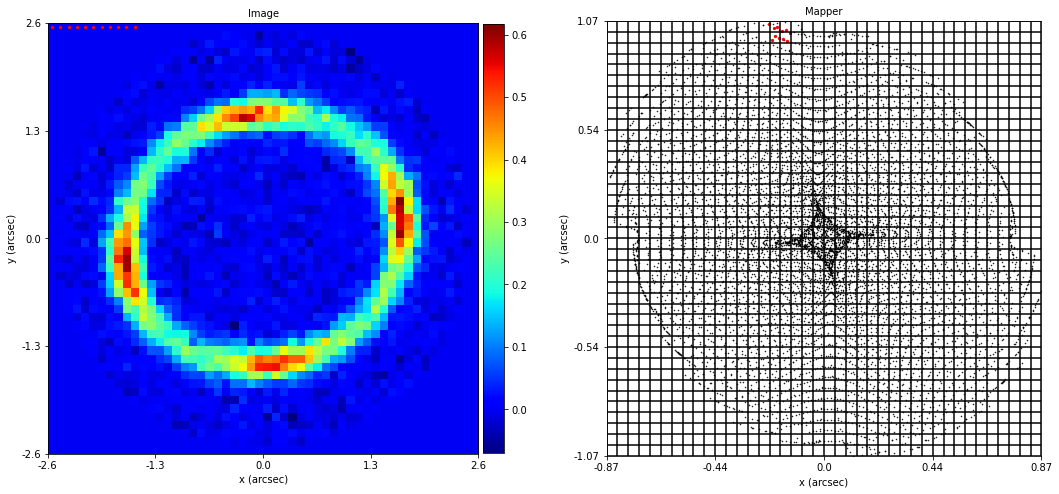

In [11]:
fit = perform_fit_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_of_planes(plane_image=True, plane_index=1)

visuals_2d = aplt.Visuals2D(indexes=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])

mapper_plotter = aplt.MapperPlotter(
    mapper=fit.inversion.mapper, visuals_2d=visuals_2d, include_2d=include_2d
)
mapper_plotter.subplot_image_and_mapper(image=fit.masked_imaging.image)

This successfully addresses both of the issues above! However, you might be thinking, isn't that a bit of a hack? Its 
not really a physical treatment of the ray-tracing, is it?

Well, you're right. However, the *only* physical way to do this would be to use a `Mask2D` so large that all demangified 
central pixels are surrounded by traced image-pixels. This would require a `Mask2D` so large our computer would crash, 
That`s not a good solution, thus borders provide us with a workaround, one that I've extensively tested and have found 
that, provided your `Mask2D` isn't too small, doesn`t lead to systematic biases.

Next, I'm going to quickly highlight how important borders are when modeling multiple lens galaxies. Their complex 
mass distribution and lensing configuration often produce very nasty edge effects where image pixels not just in the 
centre of mask, but anywhere in the mask, trace beyond the source-plane border.

we'll use new strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - There are two lens galaxies whose `MassProfile`'s are `EllipticalIsothermal``..
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

In [12]:
dataset_name = "mass_sie_x2__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.05,
)

We again must define a mask around this image, lets start with a 2.8" mask. we'll use larger masks to illustrate the
effects of the border in a moment.

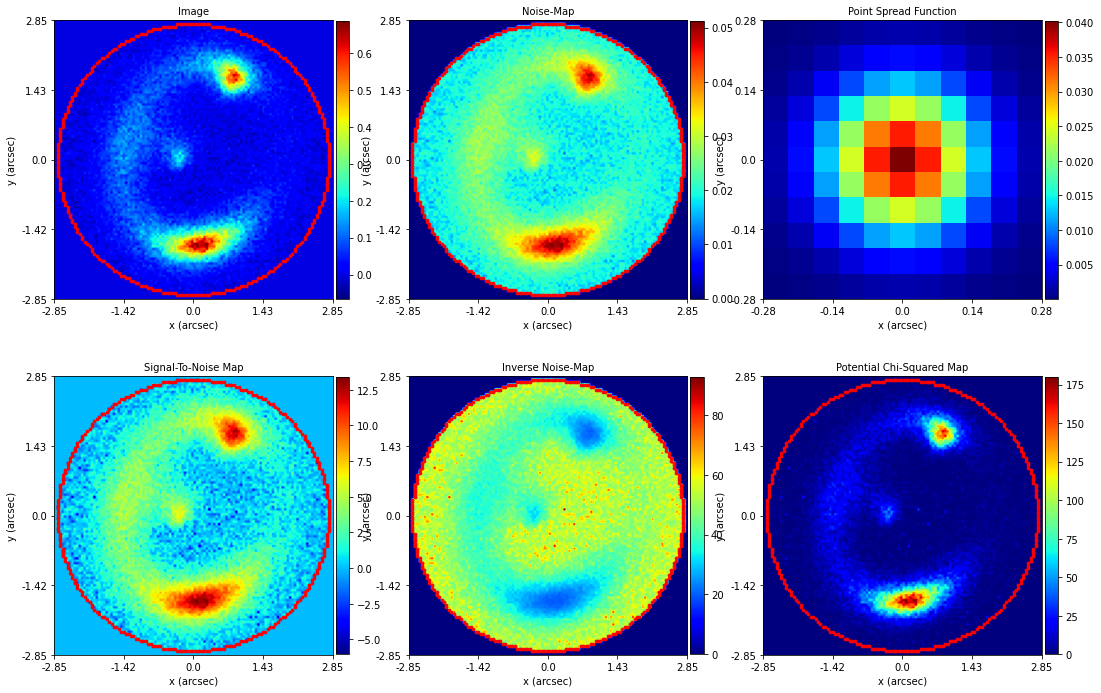

In [13]:
mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.8,
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_circular)

include_2d = aplt.Include2D(border=True)

imaging_plotter = aplt.ImagingPlotter(imaging=masked_imaging, include_2d=include_2d)
imaging_plotter.subplot_imaging()

We need to redefine our perform fit function, to use the x2 lens galaxy model.

In [14]:


def perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging, source_galaxy, mask, settings_pixelization
):

    masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

    lens_galaxy_0 = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllipticalIsothermal(
            centre=(1.1, 0.51), elliptical_comps=(0.0, 0.15), einstein_radius=1.07
        ),
    )

    lens_galaxy_1 = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllipticalIsothermal(
            centre=(-0.20, -0.35), elliptical_comps=(0.06, 0.1053), einstein_radius=0.71
        ),
    )

    tracer = al.Tracer.from_galaxies(
        galaxies=[lens_galaxy_0, lens_galaxy_1, source_galaxy]
    )

    return al.FitImaging(
        masked_imaging=masked_imaging,
        tracer=tracer,
        settings_pixelization=settings_pixelization,
    )


Now, lets fit this image using the input model and perform the source reconstruction without a border. As you can see, 
we get many demagnified image pixels which trace well beyond our source-plane border if we don't relocate them!

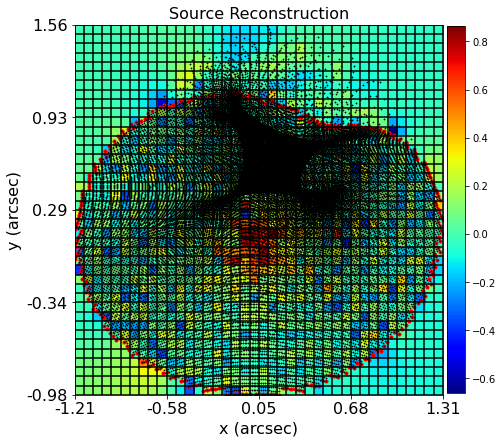

In [15]:
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=False),
)

include_2d = aplt.Include2D(mapper_source_grid_slim=True, border=True)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_of_planes(plane_image=True, plane_index=1)

However, when we relocate them, we get a good-looking source-plane with a well defined border and edge, thus ensuring 
our analysis will (hopefully) be free of systematic biases.

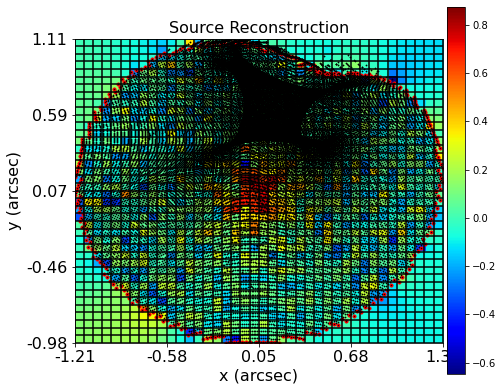

In [16]:
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_of_planes(plane_image=True, plane_index=1)

Multi-galaxy modeling is rife for border effects and if you have multiple lens galaxies I heartily recommend you pay 
a close eye to your source-plane borders!

Before we end,I want to quickly highlight that care must be taken when choosing the size of your mask. If you don't 
choose a big enough mask, the border won't be able to relocate all of the demanigified image pixels to the border edge.

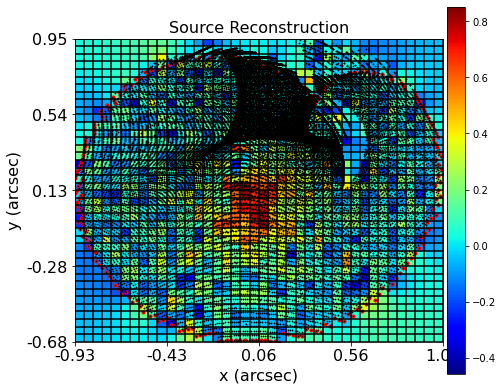

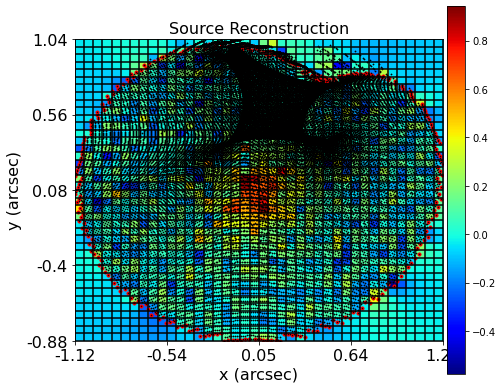

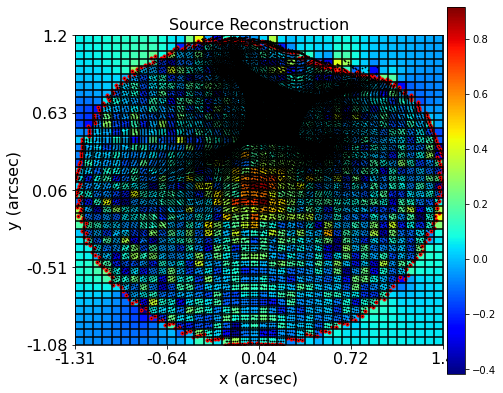

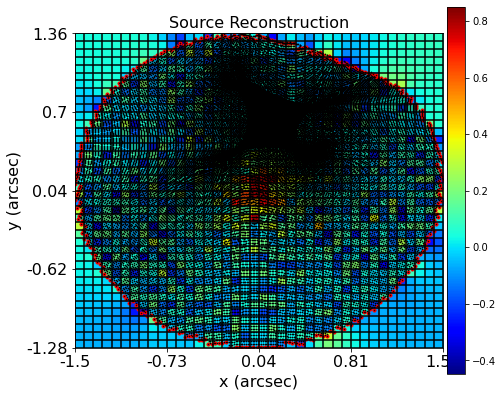

In [17]:
mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_of_planes(plane_image=True, plane_index=1)

mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.7,
)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_of_planes(plane_image=True, plane_index=1)


mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.9,
)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_of_planes(plane_image=True, plane_index=1)


mask_circular = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=3.1,
)
fit = perform_fit_x2_lenses_with_source_galaxy_mask_and_border(
    imaging=imaging,
    source_galaxy=source_galaxy,
    mask=mask_circular,
    settings_pixelization=al.SettingsPixelization(use_border=True),
)

fit_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_plotter.figures_of_planes(plane_image=True, plane_index=1)

And with that, borders are done. In truth, borders should pretty much take care of themselves when you're using 
**PyAutoLens** and you probably won't think about them much. However, as I showed above, if you don't choose a large enough 
mask things can go wrong - thus, its important you know what borders are, so you can look out for this potential 
source of systematics!